In [30]:
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.models import *
import cv2
from datetime import datetime
import time
from tqdm import tqdm
import os
from skimage import io

from matplotlib import pyplot as plt
%matplotlib inline

from unet.maskprocessor import *
from unet.normalization import *
from unet.loss import *

The purpose of this notebook is: 
   To evaluate the model performance on unseen test set.  The test set is from DigitalGlobe which is lower resolution than the MapBox satellite imageries used in training set and validation set.

Pre-requisite:
   Directory containing the source of truth MapBox street tiles.  These could be obtained via the MapBox API.
   Directory containing the inferred mask tiles.  These tiles could be generated by roadSegmentationMaskGen.py.


In [31]:
dir_truth = '/Users/jkwok/Documents/Insight/tools/jTileDownloader 2/digitalglobe/mapbox_custom_street/'
#dir_inferred = '/Users/jkwok/Documents/Insight/tools/jTileDownloader 2/digitalglobe/jackkwok.digitalglobe_harvey_3020132_tif_mask/'
dir_inferred = '/Users/jkwok/Documents/Insight/tools/jTileDownloader 2/digitalglobe/141812_post_mask/'

#model_file = '/Users/jkwok/Documents/Insight/models/Unet_Dilated-20170917-223544.hdf5'
model_file = '/Users/jkwok/Documents/Insight/models/Unet_Dilated-20170921-141812.hdf5'

model = load_model(model_file, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

In [32]:
def image_file_list(dir_path):
	""" limitation: the images files must have an image extension: webp, jpg, png, or jpeg """
	result = []
	for root, dirs, files in os.walk(dir_path):
		for file in files:
			if file.endswith('.webp') or file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
				result.append(os.path.join(root, file))
	return result

In [33]:
inferred_filelist = image_file_list(dir_inferred)

truth_filelist = []

for img_file in inferred_filelist:
    truth_file = img_file.replace(dir_inferred, dir_truth)
    truth_file = truth_file.replace('.jpg', '.png')
    truth_filelist.append(truth_file)

img_df = pd.DataFrame(
    {'infer': inferred_filelist,
     'truth': truth_filelist,
    })

img_df.head()

,infer,truth
0,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...
1,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...
2,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...
3,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...
4,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...


/Users/jkwok/Documents/Insight/tools/jTileDownloader 2/digitalglobe/141812_post_mask/16/15456/27063.jpg
/Users/jkwok/Documents/Insight/tools/jTileDownloader 2/digitalglobe/mapbox_custom_street/16/15456/27063.png
(512, 512, 3)
(512, 512, 3)
('binary mask', array([False,  True], dtype=bool))
[  0   1   2   3   4   5   7 249 250 251 252 253 254 255]
[  0 255]
0.0


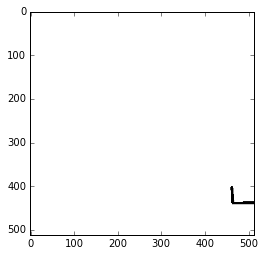

In [34]:
infer_jpg_filename = img_df.loc[0, 'infer']
truth_jpg_filename = img_df.loc[0, 'truth']
print(infer_jpg_filename)
print(truth_jpg_filename)

infer_jpg_img = cv2.imread(infer_jpg_filename)
truth_jpg_img = cv2.imread(truth_jpg_filename)

print(infer_jpg_img.shape)
print(truth_jpg_img.shape)

infer_image = cv2.cvtColor(infer_jpg_img, cv2.COLOR_BGR2GRAY)

mask = get_street_mask(truth_jpg_img)
print('binary mask', np.unique(mask))

plt.imshow(mask, cmap=plt.cm.binary)
new_style = {'grid': False}

mask.dtype='uint8'
mask[mask == 1] = 255

print(np.unique(infer_image))
print(np.unique(mask))

dice = np.sum(infer_image[mask==255])*2.0 / (np.sum(infer_image) + np.sum(mask))

print(dice)

In [35]:
# compute dice coef score between source of truth and prediction

for i in tqdm(range(len(inferred_filelist)), miniters=10):
    infer_jpg_filename = img_df.loc[i, 'infer']
    truth_jpg_filename = img_df.loc[i, 'truth']

    infer_jpg_img = cv2.imread(infer_jpg_filename)
    truth_jpg_img = cv2.imread(truth_jpg_filename)
    
    infer_image = cv2.cvtColor(infer_jpg_img, cv2.COLOR_BGR2GRAY)
    
    mask = get_street_mask(truth_jpg_img)
    mask.dtype='uint8'
    mask[mask == 1] = 255

    #print(np.unique(infer_image))
    #print(np.unique(mask))

    dice = np.sum(infer_image[mask==255])*2.0 / (np.sum(infer_image) + np.sum(mask))
    
    img_df.set_value(i, 'dice_coef', dice)


 59%|█████▊    | 169/288 [00:01<00:00, 148.23it/s]

100%|██████████| 288/288 [00:01<00:00, 149.52it/s]

In [36]:
img_df.head()

,infer,truth,dice_coef
0,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.000000
1,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.330821
2,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.000000
3,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.186144
4,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.295822


In [38]:
# 0.270229 (no blur) Unet_Dilated-20170917-223544.hdf5
# 0.305918 (with blur aug during training) Unet_Dilated-20170921-141812.hdf5

x = img_df[img_df['dice_coef']!=0]
avg_dice = x.mean()
print 'average dice score: ', avg_dice

average dice score:  dice_coef    0.305918
dtype: float64


In [39]:
sorted_df = img_df.sort_values('dice_coef', ascending=False)
sorted_df.head(10)

,infer,truth,dice_coef
188,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.923083
281,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.904406
263,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.852682
264,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.751505
38,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.676132
73,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.652336
224,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.605097
17,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.576225
211,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.573168
277,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.572108


In [ ]:
sorted_dice_file_path = data_dir + 'dice/sorted_' + os.path.splitext(model_filename)[0] + '.csv'
sorted_df.to_csv(sorted_dice_file_path, index=False)